In [5]:
# -*- coding: utf-8 -*--
# @Time    : 2022-07-22 9:00
# @Author  : zhangbowen

In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import random
from utils.utils import normalization, standardization, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
# standardization (distribution -> mean=0, std=1, [0, 1]/[-1, 1])
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
# Normalization (distribution -> constant, [0, 1])
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

# 1. Data preparation

#### read row data

In [2]:
data_path = r'data/raw_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False)
df.shape

(89383, 316)

#### options about label (power harassment)
- B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))
- B-180-843(職場で自分以外でいじめにあっている人がいる(セクハラ、パワハラを含む))
- B-181-847(私はお客様、外部関係者等からのいじめにあっている（セクハラ、パワハラ含む）)
- B-214-986(会社の同僚が辞めるとき、どんな理由による場合が多いですか？[職場でのいじめ、セクハラ・パワハラのため]) <-- use this

#### defination of label's level (4-class problem)
- level 1: そうだ 
- level 2: まあそうだ
- level 3: ややちがう
- level 4: ちがう

In [8]:
for i in range(1, 5): 
    print('level {}: {}'.format(i, sum(df['B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))']==i)))

level 1: 1402
level 2: 4442
level 3: 17429
level 4: 66110


#### label encoding (2-class problem)

In [9]:
# level 4 -> 0 (negative)
df['B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))'].replace(to_replace=4, value=0, inplace=True)
# level 1, 2, 3 -> 1 (positive)
df['B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))'].replace(to_replace=[1, 2, 3], value=1, inplace=True)

for i in range(2): 
    print('label {}: {}'.format(i, sum(df['B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))']==i)))

label 0: 66110
label 1: 23273


#### split features to category & numeric

In [10]:
category = [f for f in df.columns if df.dtypes[f] =='object'] 
numeric = [f for f in df.columns if df.dtypes[f] !='object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 26
numeric 290


#### correlation coeficient of numeric & label

In [11]:
threshold = 0.3
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = df[numeric_column]
    y = df['B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    if abs(corrcoef) >= threshold:  
        print('{}: {:.2f}'.format(numeric_column, corrcoef))

B-14-53(私の職場の雰囲気は友好的である): 0.31
B-66-261(上司は誠実な態度で対応してくれる): -0.31
B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む)): 1.00
B-180-843(職場で自分以外でいじめにあっている人がいる(セクハラ、パワハラを含む)): -0.45
B-181-847(私はお客様、外部関係者等からのいじめにあっている（セクハラ、パワハラ含む）): -0.42
C-4-4(職業性ストレス簡易調査_ストレスの原因と考えられる要素_対人関係): -0.34
C-21-21(職業性ストレス簡易調査_合計点数_合計点数): -0.36
C-28-28(新職業性ストレス簡易調査_仕事の負担_職場での対人関係): -0.35
C-46-46(新職業性ストレス簡易調査_仕事の資源（部署レベル）_上司の公正な態度): -0.31
C-62-62(新職業性ストレス簡易調査_職場のハラスメント_職場のハラスメント): -0.89
C-65-65(職業性ストレス簡易調査_ストレスの原因と考えられる要素): -0.32
C-67-67(職業性ストレス簡易調査_ストレス反応に影響を与える他の因子): -0.30
C-69-69(新職業性ストレス簡易調査_仕事の負担): -0.31
C-71-71(新職業性ストレス簡易調査_仕事の資源（部署レベル）): -0.36
C-74-74(新職業性ストレス簡易調査_職場のハラスメント): -0.89
D-376-376(仕事内容 ): -0.31
D-380-380(人間関係_上司との関係): -0.31
D-383-383(人間関係): -0.33
D-395-395(組織との関係_職場全体の関係性): -0.48
D-396-396(組織との関係): -0.36
D-417-417(エンゲージメント_エンゲージメント): -0.31
D-418-418(エンゲージメント): -0.31
D-572-572(総合ラフールネス): -0.37
D-574-574(総合ラフールネス_職場ラフールネス): -0.36


#### features selection

#### ねじり　まだ　暫く必要なし
#### objective features まだ　暫く必要なし

In [12]:
# ######### objective features ##########
# '業種大分類名称',
# '性別',
# '誕生年',　（現在 - 年齢）
# '入社年',
# '学歴名称',
# '雇用形態名称',　（職位レベル）
# '職種名称',
# '個人年収名称',
# '結婚名称',
# 'B-216-999(毎日の通勤でストレスを感じる)',　（通勤距離）
# 'B-217-1000(1ヶ月の平均的な残業時間はどれくらいか教えて下さい)',　（残業時間）


'''
July 01, 2022
feature number: 34
correlation coeficient of threshold: 0.2
not related to label
'''

# ######### subjective features ##########
# B-12-48(私の部署内で意見のくい違いがある): -0.26
# B-13-52(私の部署と他の部署とはうまが合わない): -0.26
# B-14-53(私の職場の雰囲気は友好的である): 0.31
# B-19-75(元気がいっぱいだ): -0.20
# B-21-81(怒りを感じる): 0.20
# B-22-85(内心腹立たしい): 0.24
# B-23-90(イライラしている): 0.21
# B-29-113(落着かない): 0.22
# B-30-117(ゆううつだ): 0.25
# B-33-130(気分が晴れない): 0.23
# B-34-133(仕事が手につかない): 0.23
# B-35-137(悲しいと感じる): 0.26
# B-36-141(めまいがする): 0.22
# B-37-145(体のふしぶしが痛む): 0.20
# B-42-165(動悸や息切れがする): 0.24
# B-44-176(食欲がない): 0.20
# B-56-221(仕事に満足だ): 0.21
# B-59-235(複数の人からお互いに矛盾したことを要求される): -0.24
# B-63-249(私は上司からふさわしい評価を受けている): -0.25
# B-64-256(職を失う恐れがある): -0.21
# B-65-257(上司は、部下が能力を伸ばす機会を持てるように、取り計らってくれる): -0.22
# B-66-261(上司は誠実な態度で対応してくれる): -0.31
# B-67-265(努力して仕事をすれば、ほめてもらえる): -0.26
# B-68-269(失敗しても挽回(ばんかい)するチャンスがある職場だ): -0.27
# B-71-281(一人ひとりの価値観を大事にしてくれる職場だ): -0.21
# B-73-289(職場では、（正規、非正規、アルバイトなど）いろいろな立場の人が職場の一員として尊重されている): -0.22
# B-78-309(私たちの職場では、お互いに理解し認め合っている): -0.29
# B-171-804(自分の仕事には十分裁量が与えられている): -0.23
# B-182-848(私の部署はよく機能している（コミュニケーション・指示命令など）): -0.22
# B-188-875(職場で、好ましくない変化を経験している、もしくは今後そういう状況が起こりうる): -0.24
# B-194-899(職場は騒音でうるさく集中できない): -0.21
# B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？): -0.20
# B-212-972(部署を変わりたい): -0.22
# B-219-1009(ストレスを上手に解消・発散できる): -0.20




'''
July 22, 2022
feature number: 11
correlation coeficient of threshold: 0.3
not related to label
'''

# ######### subjective features ##########
# B-14-53(私の職場の雰囲気は友好的である): 0.31
# B-66-261(上司は誠実な態度で対応してくれる): -0.31

# D-376-376(仕事内容 ): -0.31
# D-380-380(人間関係_上司との関係): -0.31
# D-383-383(人間関係): -0.33
# D-395-395(組織との関係_職場全体の関係性): -0.48
# D-396-396(組織との関係): -0.36
# D-417-417(エンゲージメント_エンゲージメント): -0.31
# D-418-418(エンゲージメント): -0.31
# D-572-572(総合ラフールネス): -0.37
# D-574-574(総合ラフールネス_職場ラフールネス): -0.36

'\nJuly 22, 2022\nfeature number: 11\ncorrelation coeficient of threshold: 0.3\nnot related to label\n'

#### summarize features & label into a dataframe

In [13]:
'''
July 01, 2022
feature number: 34
correlation coeficient of threshold: 0.2
not related to label
'''

'''
new_df = pd.DataFrame(df, columns=[
    'B-12-48(私の部署内で意見のくい違いがある)', # features
    'B-13-52(私の部署と他の部署とはうまが合わない)',
    'B-14-53(私の職場の雰囲気は友好的である)',
    'B-19-75(元気がいっぱいだ)',
    'B-21-81(怒りを感じる)',
    'B-22-85(内心腹立たしい)',
    'B-23-90(イライラしている)',
    'B-29-113(落着かない)',
    'B-30-117(ゆううつだ)',
    'B-33-130(気分が晴れない)',
    'B-34-133(仕事が手につかない)',
    'B-35-137(悲しいと感じる)',
    'B-36-141(めまいがする)',
    'B-37-145(体のふしぶしが痛む)',
    'B-42-165(動悸や息切れがする)',
    'B-44-176(食欲がない)',
    'B-56-221(仕事に満足だ)',
    'B-59-235(複数の人からお互いに矛盾したことを要求される)',
    'B-63-249(私は上司からふさわしい評価を受けている)',
    'B-64-256(職を失う恐れがある)',
    'B-65-257(上司は、部下が能力を伸ばす機会を持てるように、取り計らってくれる)',
    'B-66-261(上司は誠実な態度で対応してくれる)',
    'B-67-265(努力して仕事をすれば、ほめてもらえる)',
    'B-68-269(失敗しても挽回(ばんかい)するチャンスがある職場だ)',
    'B-71-281(一人ひとりの価値観を大事にしてくれる職場だ)',
    'B-73-289(職場では、（正規、非正規、アルバイトなど）いろいろな立場の人が職場の一員として尊重されている)',
    'B-78-309(私たちの職場では、お互いに理解し認め合っている)',
    'B-171-804(自分の仕事には十分裁量が与えられている)',
    'B-182-848(私の部署はよく機能している（コミュニケーション・指示命令など）)',
    'B-188-875(職場で、好ましくない変化を経験している、もしくは今後そういう状況が起こりうる)',
    'B-194-899(職場は騒音でうるさく集中できない)',
    'B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)',
    'B-212-972(部署を変わりたい)',
    'B-219-1009(ストレスを上手に解消・発散できる)',
    'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))' # label
])

new_df.shape
'''




'''
July 22, 2022
feature number: 11
correlation coeficient of threshold: 0.3
not related to label
'''

new_df = pd.DataFrame(df, columns=[
    'B-14-53(私の職場の雰囲気は友好的である)', # features
    'B-66-261(上司は誠実な態度で対応してくれる)',
    'D-376-376(仕事内容 )',
    'D-380-380(人間関係_上司との関係)',
    'D-383-383(人間関係)',
    'D-395-395(組織との関係_職場全体の関係性)',
    'D-396-396(組織との関係)',
    'D-417-417(エンゲージメント_エンゲージメント)',
    'D-418-418(エンゲージメント)',
    'D-572-572(総合ラフールネス)',
    'D-574-574(総合ラフールネス_職場ラフールネス)',
    'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))' # label
])

new_df.shape

(89383, 12)

#### feature & label names' datatype conversion

In [14]:
'''
July 01, 2022
feature number: 34
correlation coeficient of threshold: 0.2
not related to label
'''

'''
# japanese -> english
new_df = new_df.rename(columns={
    'B-12-48(私の部署内で意見のくい違いがある)': 'x1', # features
    'B-13-52(私の部署と他の部署とはうまが合わない)': 'x2',
    'B-14-53(私の職場の雰囲気は友好的である)': 'x3',
    'B-19-75(元気がいっぱいだ)': 'x4',
    'B-21-81(怒りを感じる)': 'x5',
    'B-22-85(内心腹立たしい)': 'x6',
    'B-23-90(イライラしている)': 'x7',
    'B-29-113(落着かない)': 'x8',
    'B-30-117(ゆううつだ)': 'x9',
    'B-33-130(気分が晴れない)': 'x10',
    'B-34-133(仕事が手につかない)': 'x11',
    'B-35-137(悲しいと感じる)': 'x12',
    'B-36-141(めまいがする)': 'x13',
    'B-37-145(体のふしぶしが痛む)': 'x14',
    'B-42-165(動悸や息切れがする)': 'x15',
    'B-44-176(食欲がない)': 'x16',
    'B-56-221(仕事に満足だ)': 'x17',
    'B-59-235(複数の人からお互いに矛盾したことを要求される)': 'x18',
    'B-63-249(私は上司からふさわしい評価を受けている)': 'x19',
    'B-64-256(職を失う恐れがある)': 'x20',
    'B-65-257(上司は、部下が能力を伸ばす機会を持てるように、取り計らってくれる)': 'x21',
    'B-66-261(上司は誠実な態度で対応してくれる)': 'x22',
    'B-67-265(努力して仕事をすれば、ほめてもらえる)': 'x23',
    'B-68-269(失敗しても挽回(ばんかい)するチャンスがある職場だ)': 'x24',
    'B-71-281(一人ひとりの価値観を大事にしてくれる職場だ)': 'x25',
    'B-73-289(職場では、（正規、非正規、アルバイトなど）いろいろな立場の人が職場の一員として尊重されている)': 'x26',
    'B-78-309(私たちの職場では、お互いに理解し認め合っている)': 'x27',
    'B-171-804(自分の仕事には十分裁量が与えられている)': 'x28',
    'B-182-848(私の部署はよく機能している（コミュニケーション・指示命令など）)': 'x29',
    'B-188-875(職場で、好ましくない変化を経験している、もしくは今後そういう状況が起こりうる)': 'x30',
    'B-194-899(職場は騒音でうるさく集中できない)': 'x31',
    'B-209-957(入社前の期待と入社後の現実でどの程度ギャップがありますか？)': 'x32',
    'B-212-972(部署を変わりたい)': 'x33',
    'B-219-1009(ストレスを上手に解消・発散できる)': 'x34',
    'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))': 'Y' # label
})
'''




'''
July 22, 2022
feature number: 11
correlation coeficient of threshold: 0.3
not related to label
'''

# japanese -> english
new_df = new_df.rename(columns={
    'B-14-53(私の職場の雰囲気は友好的である)': 'x1', # features
    'B-66-261(上司は誠実な態度で対応してくれる)': 'x2',
    'D-376-376(仕事内容 )': 'x3',
    'D-380-380(人間関係_上司との関係)': 'x4',
    'D-383-383(人間関係)': 'x5',
    'D-395-395(組織との関係_職場全体の関係性)': 'x6',
    'D-396-396(組織との関係)': 'x7',
    'D-417-417(エンゲージメント_エンゲージメント)': 'x8',
    'D-418-418(エンゲージメント)': 'x9',
    'D-572-572(総合ラフールネス)': 'x10',
    'D-574-574(総合ラフールネス_職場ラフールネス)': 'x11',
    'B-77-308(職場で自分がいじめにあっている (セクハラ、パワハラを含む))': 'Y' # label
})

# 2. Data analysis

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89383 entries, 0 to 89382
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      89383 non-null  float64
 1   x2      89383 non-null  float64
 2   x3      89383 non-null  float64
 3   x4      89383 non-null  float64
 4   x5      89383 non-null  float64
 5   x6      89383 non-null  float64
 6   x7      89383 non-null  float64
 7   x8      89383 non-null  float64
 8   x9      89383 non-null  float64
 9   x10     89383 non-null  float64
 10  x11     89383 non-null  float64
 11  Y       89383 non-null  float64
dtypes: float64(12)
memory usage: 8.2 MB


#### numeri: count, mean, std, min, 25%, 50%, 75%, max

In [12]:
new_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,Y
count,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000
mean,1.951557,2.999866,53.344535,64.801212,70.290592,61.909808,58.402217,59.788879,59.788879,57.894333,57.720680,0.260374
std,0.767640,0.776996,13.626827,21.968279,16.346525,17.049113,14.862733,15.349938,15.349938,12.719300,13.356125,0.438841
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.970000,-0.370000,0.000000
25%,1.000000,3.000000,45.240000,53.330000,61.110000,51.520000,49.590000,50.450000,50.450000,50.120000,49.630000,0.000000
50%,2.000000,3.000000,54.760000,66.670000,69.450000,63.640000,59.350000,60.360000,60.360000,58.150000,58.520000,0.000000
75%,2.000000,4.000000,61.910000,80.000000,80.560000,72.730000,67.480000,69.370000,69.370000,66.180000,66.300000,1.000000
max,4.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.270000,100.000000,1.000000


#### split features to category & numeric

In [13]:
category = [f for f in new_df.columns if new_df.dtypes[f] == 'object'] 
numeric = [f for f in new_df.columns if new_df.dtypes[f] != 'object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 0
numeric 12


#### relationship of numeric & label

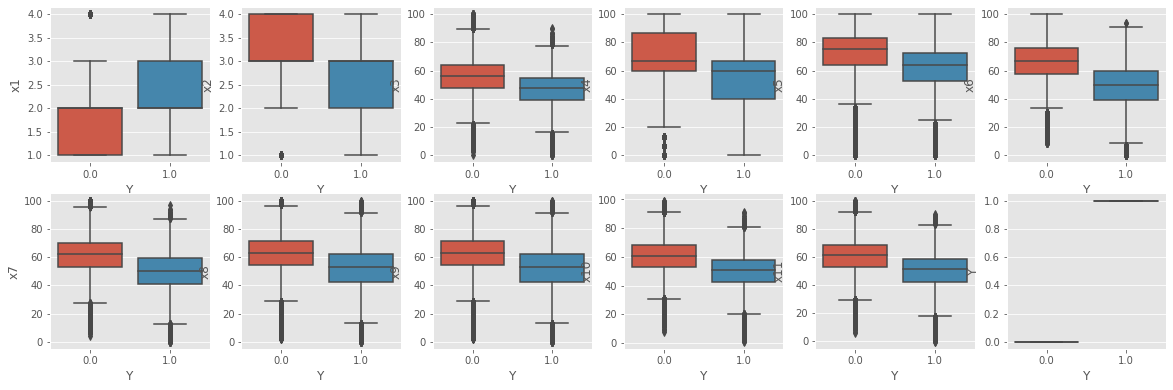

In [14]:
'''
sns.barplot() -> (mean)
sns.boxplot() -> (max, upper quartile, median, lower quartile, min)
sns.violinplot() -> (density distribution)
plt.scatter() -> (all datapoints)
sns.swarmplot -> (all datapoints)
'''
plt.figure(figsize=(20, 20))
for numeric_column in numeric:
    plt.subplot(6, 6, numeric.index(numeric_column)+1)
    sns.boxplot(data=new_df, x='Y', y=numeric_column)
plt.show()

#### distribution of numeric

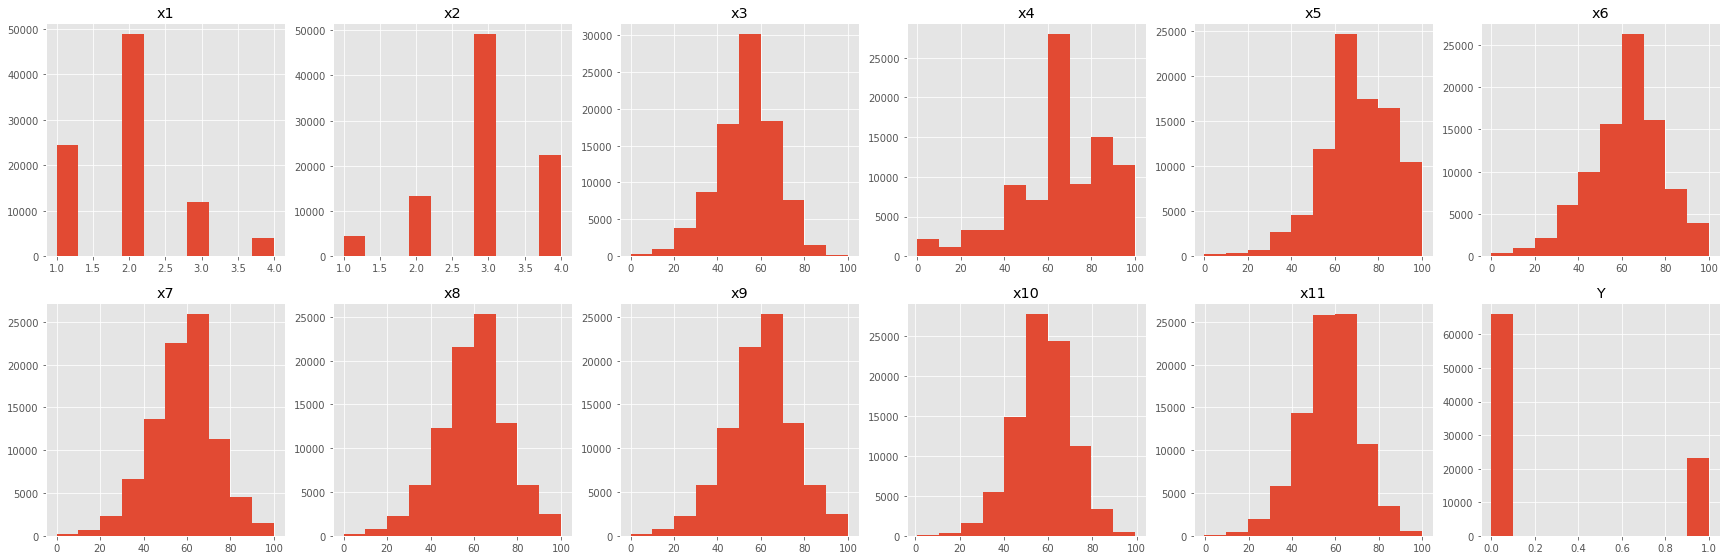

In [15]:
plt.figure(figsize=(30, 30))
for numeric_column in numeric:
    plt.subplot(6, 6, numeric.index(numeric_column)+1)
    plt.title(numeric_column)
    new_df[numeric_column].hist()
plt.show()

#### correlation coeficient of numeric & label

In [16]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = new_df[numeric_column]
    y = new_df['Y']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    print('{}: {:.2f}'.format(numeric_column, corrcoef))

x1: 0.31
x2: -0.31
x3: -0.31
x4: -0.31
x5: -0.33
x6: -0.48
x7: -0.36
x8: -0.31
x9: -0.31
x10: -0.37
x11: -0.36
Y: 1.00


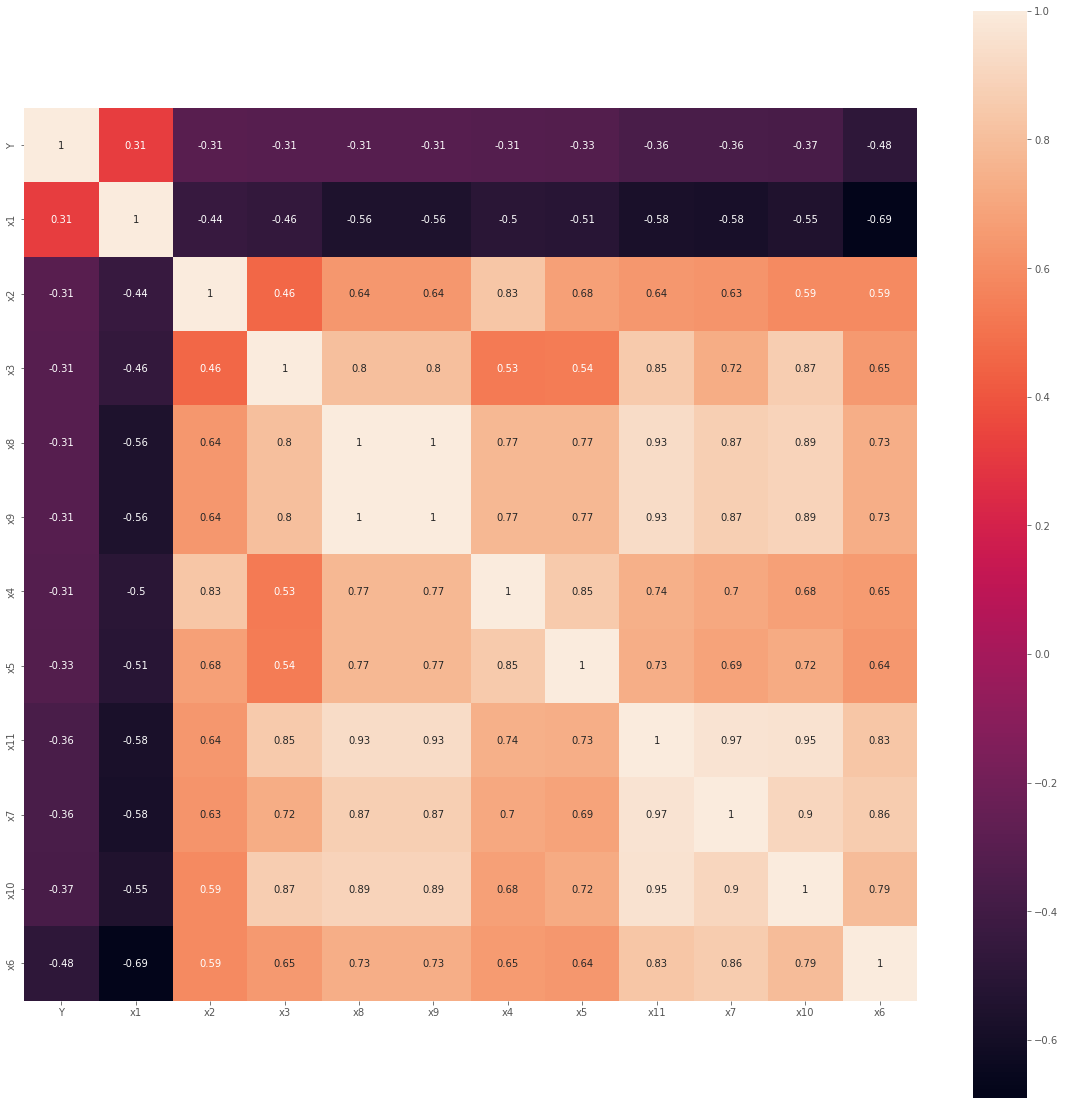

In [17]:
corrcoef_matrix = new_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrcoef_matrix, annot=True, square=True)
plt.show()

# 3. Data preprocessing

#### standardization & normalization of numeric

In [18]:
scaler = MinMaxScaler()

'''
July 01, 2022
feature number: 34
correlation coeficient of threshold: 0.2
not related to label
'''

'''
norm_list = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
             'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
             'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
             'x31', 'x32', 'x33', 'x34'
]
'''




'''
July 22, 2022
feature number: 11
correlation coeficient of threshold: 0.3
not related to label
'''
norm_list = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
             'x11'
]

for column in norm_list:
    new_df[column] = scaler.fit_transform(new_df[column].values.reshape(-1, 1))  

In [19]:
new_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,Y
count,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000
mean,0.317186,0.666622,0.533445,0.648012,0.702906,0.619098,0.584022,0.597889,0.597889,0.579088,0.578765,0.260374
std,0.255880,0.258999,0.136268,0.219683,0.163465,0.170491,0.148627,0.153499,0.153499,0.129393,0.133069,0.438841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.666667,0.452400,0.533300,0.611100,0.515200,0.495900,0.504500,0.504500,0.500000,0.498157,0.000000
50%,0.333333,0.666667,0.547600,0.666700,0.694500,0.636400,0.593500,0.603600,0.603600,0.581689,0.586729,0.000000
75%,0.333333,1.000000,0.619100,0.800000,0.805600,0.727300,0.674800,0.693700,0.693700,0.663377,0.664242,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. Feature selection

#### check feature importance via Lasso

feature importance via Lasso
     Feature Importance
x7         3.270425e-01
x8         8.727342e-02
x9         1.423768e-15
x4         0.000000e+00
x10       -0.000000e+00
x11        0.000000e+00
x1        -1.413893e-02
x3        -4.220446e-02
x2        -8.482062e-02
x5        -8.747455e-02
x6        -1.370639e+00


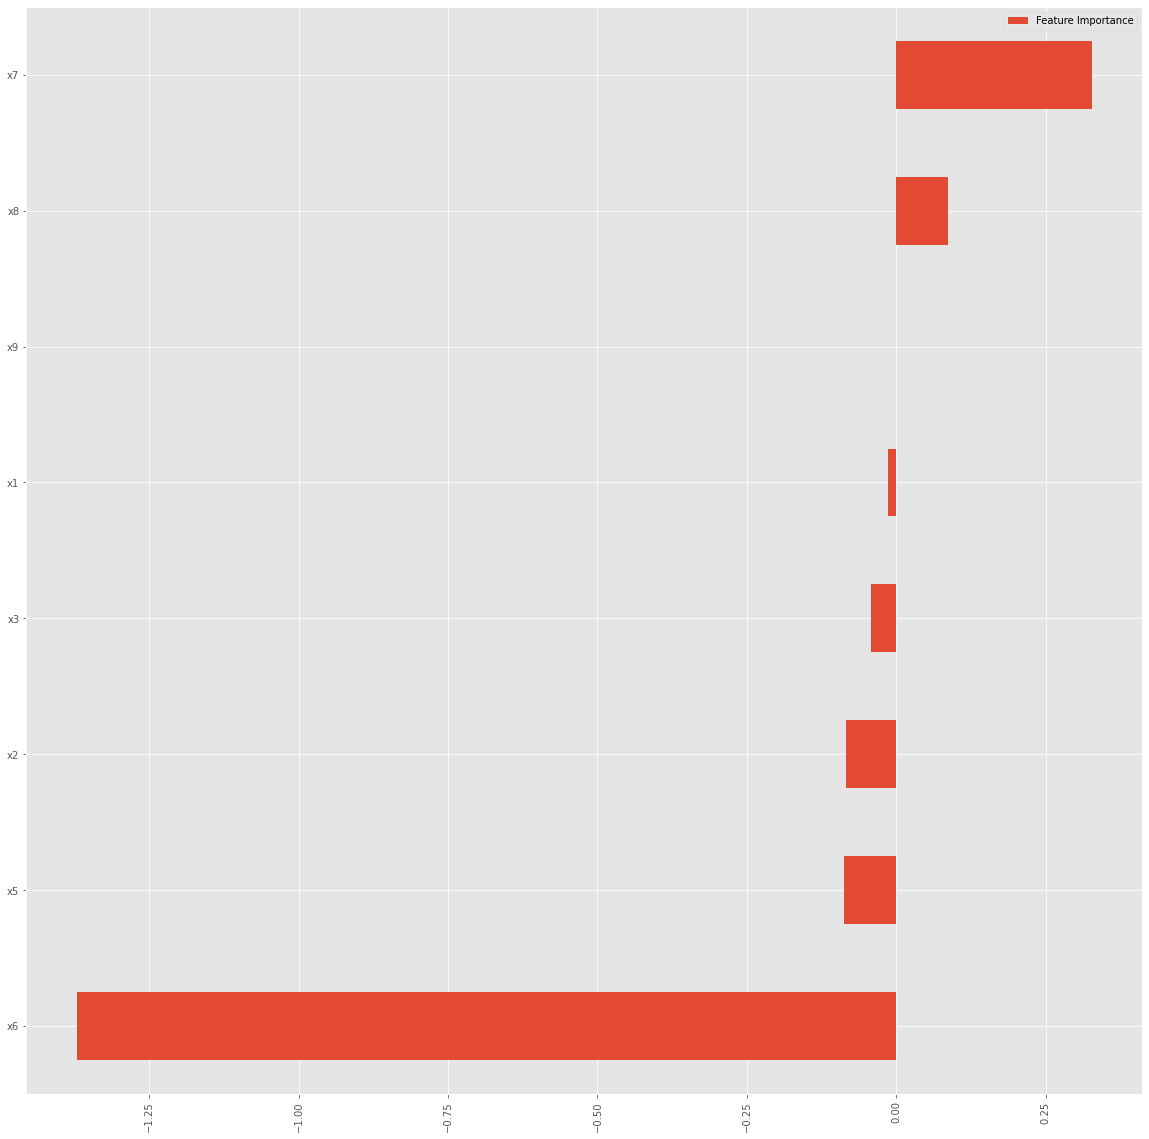

In [20]:
lasso=Lasso(alpha=0.001) # if alpha is so large, coefficients tend to become 0
lasso.fit(new_df.iloc[:, 0:-1], new_df.iloc[:, -1])

FI_lasso = pd.DataFrame({'Feature Importance':lasso.coef_}, index=new_df.columns[0: -1])
print('feature importance via Lasso')
# rank feature importance
print(FI_lasso.sort_values('Feature Importance', ascending=False))
# visualize feature importance
FI_lasso[FI_lasso['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh', figsize=(20, 20))
plt.xticks(rotation=90)
plt.show()

#### select only top n features to use

In [21]:
threshold = 0.05

ranked_features = FI_lasso.sort_values('Feature Importance', ascending=False)['Feature Importance']
selected_features = []
for key, value in ranked_features.items():
    if value >= threshold:
        selected_features.append(key)
    else:
        break
len(selected_features)

2

In [22]:
# selected_features.append('Y')
# new_df = new_df[selected_features]
# new_df

# 5. label balance

#### current balance

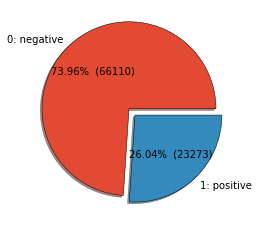

In [23]:
a = new_df.loc[new_df['Y']==0].count()[0]
b = new_df.loc[new_df['Y']==1].count()[0]
values = [a, b]
labels = ['0: negative', '1: positive']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### downsampling (randomly select b (1: positive) from a (0: negative))

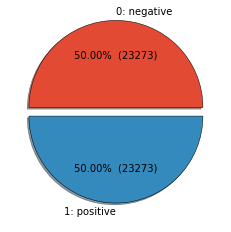

In [24]:
# 0: negative
new_df_0 = new_df[new_df['Y']==0].iloc[np.random.randint(0, a, size=b)]
# 1: positive
new_df_1 = new_df[new_df['Y']==1]
# merge
new_df = pd.concat([new_df_0, new_df_1])


a = new_df.loc[new_df['Y']==0].count()[0]
b = new_df.loc[new_df['Y']==1].count()[0]
values = [a, b]
labels = ['0: negative', '1: positive']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### dataframe -> csv

In [25]:
# original number of data
new_df.to_csv('data/PowerHarassment/data_utf-8.csv', index=False) # index=False: no write index
# upsampled data
# sample_features.to_csv('data/data_utf-8.csv', index=True)

# 6. Load &  split data for training 

#### read pre-processed data

In [26]:
data_path = r'data/PowerHarassment/data_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,Y
count,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000,46546.000000
mean,0.360754,0.624157,0.510290,0.611552,0.674862,0.573983,0.554268,0.572157,0.572157,0.552937,0.552250,0.500000
std,0.267655,0.269091,0.137179,0.228311,0.167454,0.177397,0.150994,0.156035,0.156035,0.131316,0.135331,0.500005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.428600,0.466700,0.583300,0.454500,0.463400,0.477500,0.477500,0.472838,0.468666,0.000000
50%,0.333333,0.666667,0.523800,0.666700,0.666700,0.575800,0.561000,0.585600,0.585600,0.556968,0.560925,0.500000
75%,0.333333,0.666667,0.595300,0.733300,0.777800,0.697000,0.650400,0.666700,0.666700,0.636114,0.638338,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992574,1.000000,1.000000


#### split dataframe -> features & label -> train & test

In [27]:
features = df.iloc[:, 0:-1]
label = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1234, stratify=label)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37236, 11), (9310, 11), (37236,), (9310,))

# 7. PCA

In [42]:
# model
pca = PCA(n_components=10, random_state=1234)
# train
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((37236, 10), (9310, 10))

#### visualize PC distribution

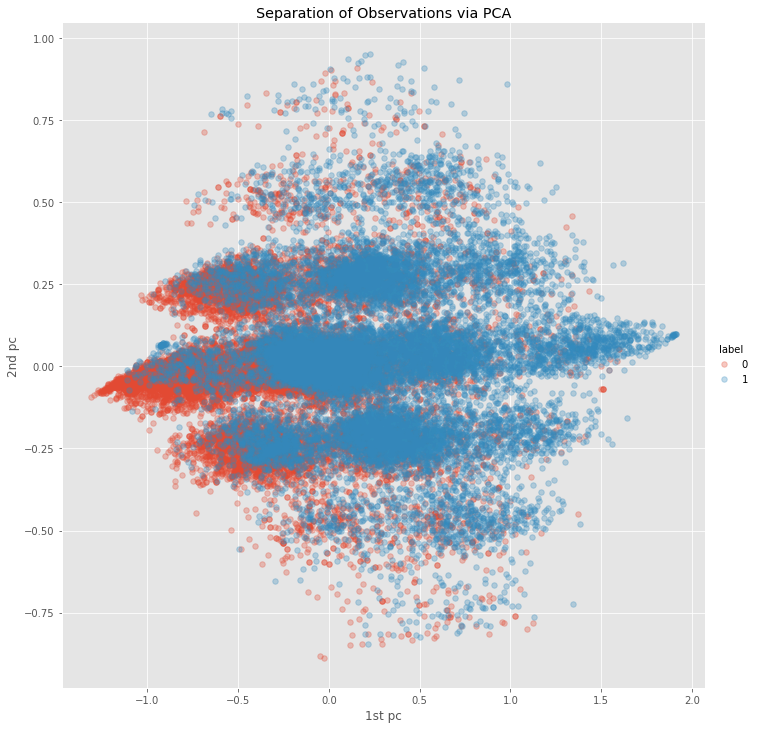

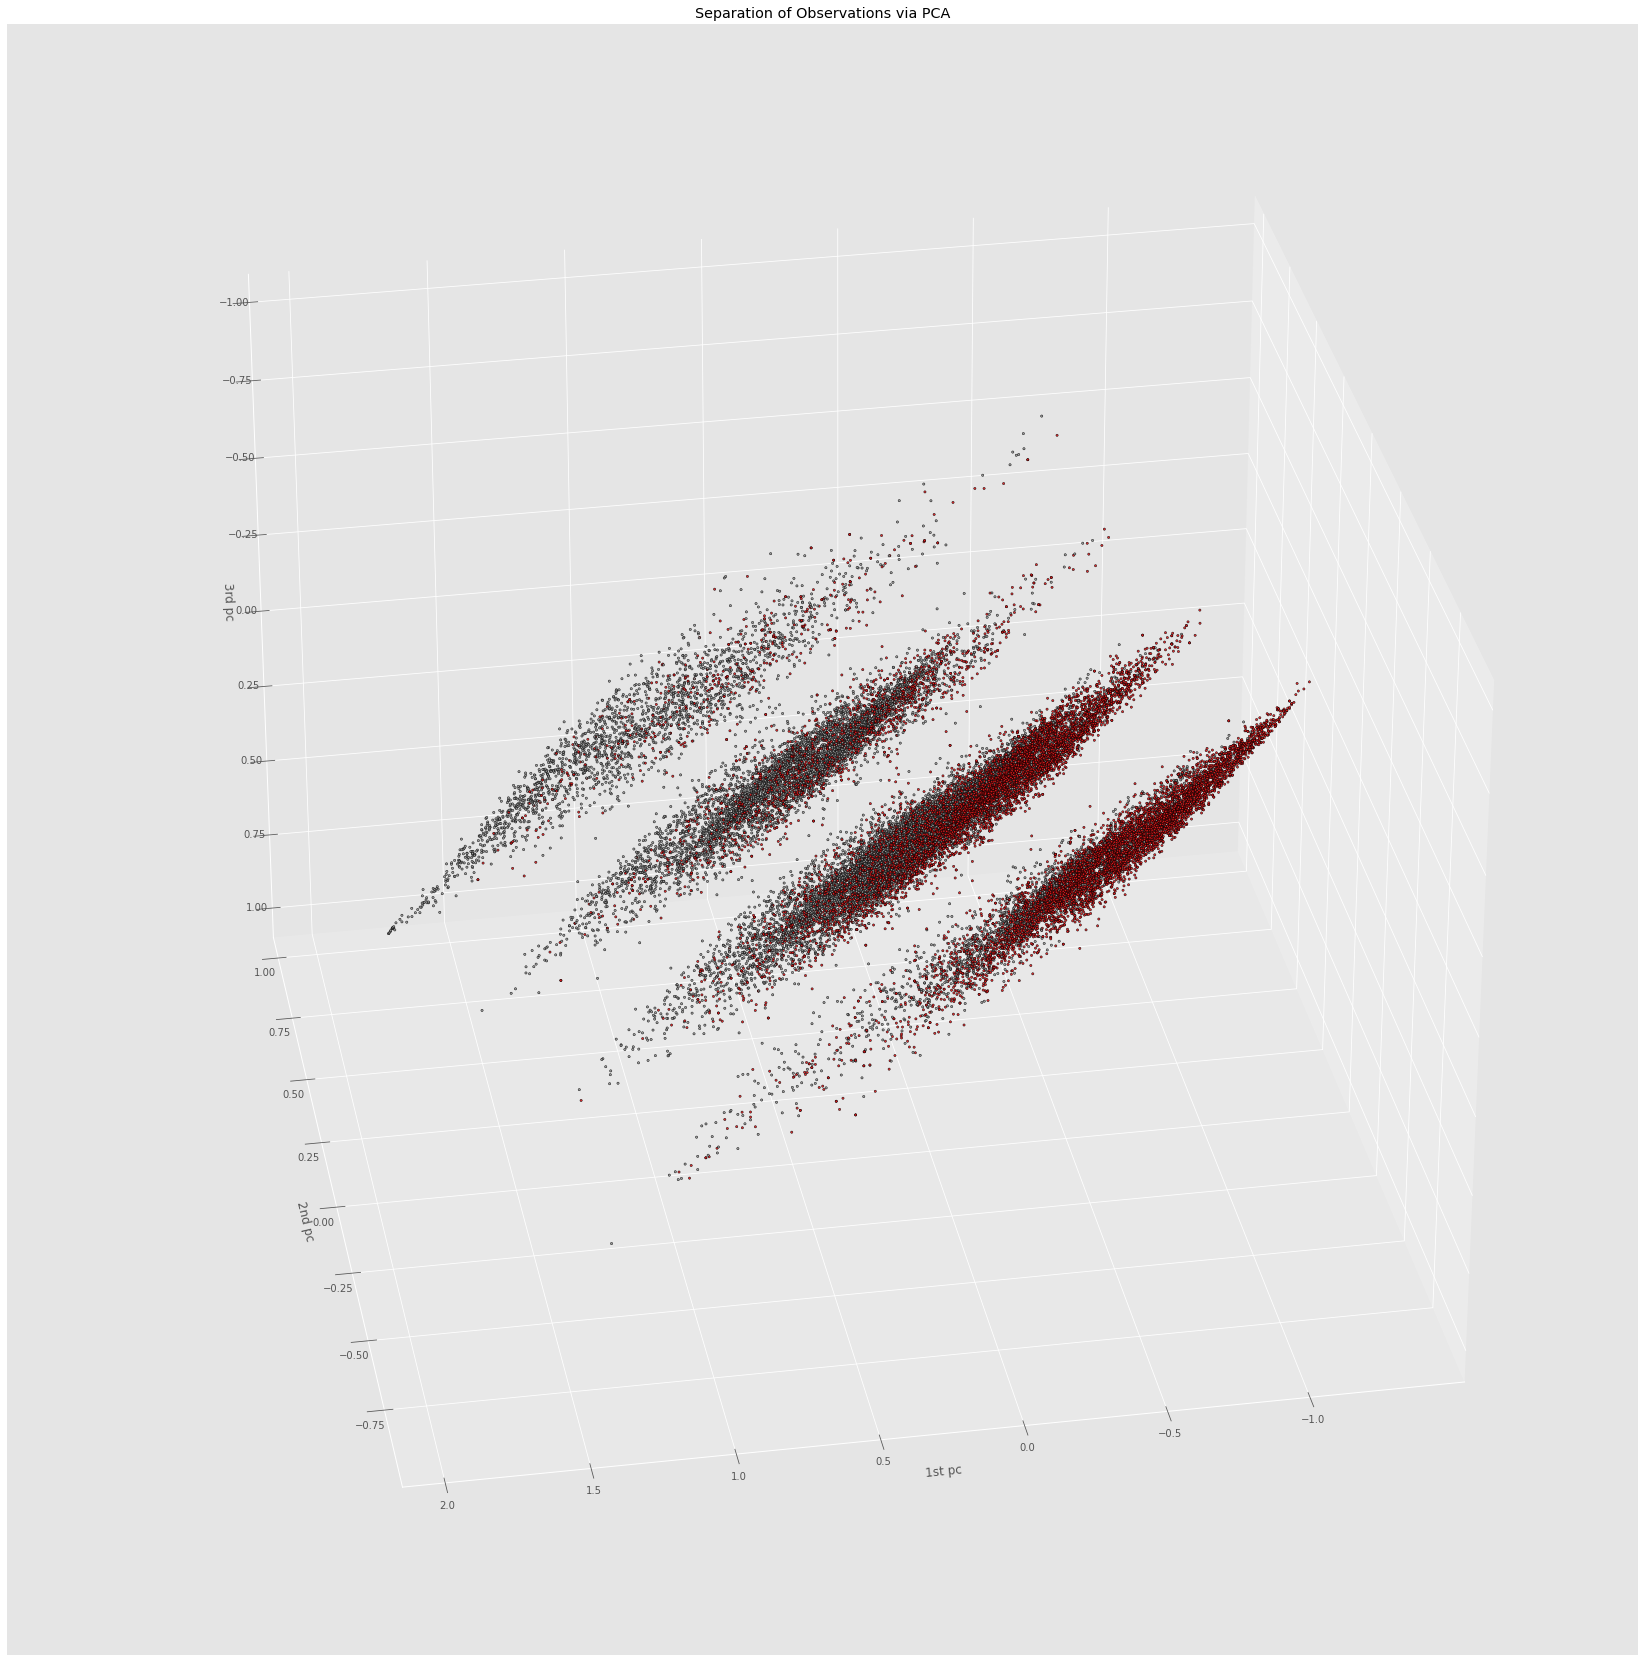

In [43]:
# plot 2D
def plot_2d_pc(xDF, yDF, first_PC, second_PC, algoName):
    tempDF = pd.DataFrame(data=pd.concat((xDF.loc[:, first_PC], xDF.loc[:, second_PC]), axis=1, join='inner'), index=xDF.index)

    tempDF = pd.concat((tempDF, yDF), axis=1, join='inner')
    tempDF.columns = ['1st pc', '2nd pc', 'label']

    sns.lmplot(x='1st pc', y='2nd pc', hue='label',
            data=tempDF, fit_reg=False, height=10,
            scatter_kws={'alpha':0.3, 's':30}
    )
    ax = plt.gca()
    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# plot 3D
def plot_3d_pc(xDF, yDF, first_PC, second_PC, third_PC, algoName):
    fig = plt.figure(1, figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d', elev=-150, azim=100)
    ax.set_xlabel('1st pc')
    ax.set_ylabel('2nd pc')
    ax.set_zlabel('3rd pc')
    ax.scatter(
        X_train_pca[:, 0],
        X_train_pca[:, 1],
        X_train_pca[:, 2],
        c=y_train, cmap=plt.cm.Set1, 
        edgecolor='k', s=5, alpha=0.9
    )

    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# ndarray -> dataframe for visualization
df_X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

# plot 2D 
plot_2d_pc(df_X_train_pca, y_train, 0, 1, 'PCA')

# plot 3D 
plot_3d_pc(df_X_train_pca, y_train, 0, 1, 2, 'PCA')

In [408]:
# original (not pca)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71506, 11), (71506,), (17877, 11), (17877,))

In [409]:
# pca
X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape

((71506, 3), (71506,), (17877, 3), (17877,))

# 8. Modeling & Evaluation (train)

#### classification

In [410]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


models = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(),
          KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()
]

names = ['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier', 
         'KNeighborsClassifier', 'GaussianNB', 'RandomForestClassifier'
]

#### score function (K-folds) 
[avalibel metrcs of cross vall](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [458]:
num_folds = 5

def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=num_folds)

    return acc

def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=num_folds)

    return balanced_acc

def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision_weighted', cv=num_folds)

    return precision


def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall_weighted', cv=num_folds)

    return recall


def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1_weighted', cv=num_folds)

    return f1_score


def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=num_folds)

    return auc

In [459]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    
    # acc
    score = acc_cv(model, X_train, y_train)
    print('||{}||    ||acc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # balanced acc
    score = balanced_acc_cv(model, X_train, y_train)
    print('||{}||    ||balanced_acc_cv||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # X_train
    score = precision_cv(model, X_train_pca, y_train)
    print('||{}||    ||precision_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # recall
    score = recall_cv(model, X_train, y_train)
    print('||{}||    ||recall_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # f1-score
    score = f1_score_cv(model, X_train, y_train)
    print('||{}||    ||f1-score_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # auc
    score = auc_cv(model, X_train, y_train)
    print('||{}||    ||auc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

---------- LogisticRegression ----------
||LogisticRegression||    ||acc||    mean sore: 0.7796    std score: 0.0021
||LogisticRegression||    ||balanced_acc_cv||    mean sore: 0.6372    std score: 0.0090
||LogisticRegression||    ||precision_weighted||    mean sore: 0.7527    std score: 0.0043
||LogisticRegression||    ||recall_weighted||    mean sore: 0.7796    std score: 0.0021
||LogisticRegression||    ||f1-score_weighted||    mean sore: 0.7538    std score: 0.0050
||LogisticRegression||    ||auc||    mean sore: 0.6372    std score: 0.0090
---------- DecisionTreeClassifier ----------
||DecisionTreeClassifier||    ||acc||    mean sore: 0.7184    std score: 0.0023
||DecisionTreeClassifier||    ||balanced_acc_cv||    mean sore: 0.6418    std score: 0.0053
||DecisionTreeClassifier||    ||precision_weighted||    mean sore: 0.7054    std score: 0.0025
||DecisionTreeClassifier||    ||recall_weighted||    mean sore: 0.7184    std score: 0.0034
||DecisionTreeClassifier||    ||f1-score_weigh

# 10. Hyperparameters Tuning (Grid Search / Randomized Search)

In [453]:
num_folds = 5

# 1-metric
# metrics = 'precision_weighted'
# metrics = 'recall_weighted'
metrics = 'f1_weighted'
# metrics = make_scorer(roc_auc_score)

class GridSearch():
    '''
    search only all the setted parameters 
    '''
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring=metrics, cv=num_folds)
        grid_search.fit(X, y)
        
        # print the best
        print('best params: ', grid_search.best_params_)
        print('best score: ', grid_search.best_score_)
        print('best estimator: ', grid_search.best_estimator_)
        
        # print all the process
        print(pd.DataFrame(grid_search.cv_results_)[['params']])



class RandomizedSearch():
    '''
    randomly search e.g. 1000 times
    '''
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, random_grid):
        grid_search = GridSearchCV(estimator=self.model, param_distributions=random_grid, scoring=metrics, cv=num_folds, n_iter=100, verbose=2, random_state=42, n_jobs=-1)
        grid_search.fit(X, y)

        # print the best
        print('best params: ', grid_search.best_params_)
        print('best score: ', grid_search.best_score_)
        print('best estimator: ', grid_search.best_estimator_)
        
        # print all the process
        print(pd.DataFrame(grid_search.cv_results_)[['params']])

#### DecisionTreeClassifier

In [1]:
param_grid = {
    'criterion': ('gini', 'entropy'), 
    'splitter': ('best', 'random'), 
    'max_depth': (list(range(1, 20))), 
    'min_samples_split': [2, 3, 4], 
    'min_samples_leaf':list(range(1, 20)), 
}

grid = GridSearch(DecisionTreeClassifier(random_state=1234))
grid.grid_get(X_train, y_train, param_grid)       

#### XGBClassifier

In [454]:
param_grid = {
    'eta':[0.01, 0.1, 1.0],
    'gamma':[0, 0.1], 
    'n_estimators':[10, 100],
    'max_depth':[2, 4], 
    'min_child_weigh':[1, 2],
    'nthread':[2]
}

grid = GridSearch(XGBClassifier(random_state=1234, verbosity=0))
grid.grid_get(X_train, y_train, param_grid)

best params:  {'eta': 1.0, 'gamma': 0, 'max_depth': 2, 'min_child_weigh': 1, 'n_estimators': 10, 'nthread': 2}
best score:  0.6306214834165269
best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=1.0,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weigh=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=2, nthread=2,
              num_parallel_tree=1, predictor='auto', ...)
                                               params
0   {'eta': 0.01, 'gamma': 0, 'max_depth': 2, 'min...
1   {'eta': 0.01, 'gamma': 0, 'max_depth': 2, 'min...
2   {'et

#### RandomForestClassifier

In [2]:
param_grid = {
    'n_estimators': [100, 500, 1000, 1500], 
    'max_features': ['auto', 'sqrt'],
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True, False]
}

grid = GridSearch(RandomForestClassifier(random_state=1234))
grid.grid_get(X_train, y_train, param_grid)

In [ ]:
random_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)].append(None),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


grid = RandomizedSearch(RandomForestClassifier(random_state=1234))
grid.grid_get(X_train, y_train, param_grid)

# 11. model combination

In [ ]:
# 加权平均(Average Weight)
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

# 根据 Grid Search 的分数来分配权重
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

# 执行上面函数
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
print('Lasso,ridge,svr,ker,ela,bay的分数:',rmse_cv(weight_avg,X_scaled,y_log),'平均分数:',rmse_cv(weight_avg,X_scaled,y_log).mean())

In [ ]:
# 尝试了不同组合之后发现svr和ker的组合误差最小
weight_avg = AverageWeight(mod = [ela,bay],weight=[0.5,0.5])
print('ela,bay的分数:',rmse_cv(weight_avg,X_scaled,y_log),'平均分数:',rmse_cv(weight_avg,X_scaled,y_log).mean())

weight_avg = AverageWeight(mod = [lasso,ridge],weight=[0.5,0.5])
print('lasso,ridge的分数:',rmse_cv(weight_avg,X_scaled,y_log),'平均分数:',rmse_cv(weight_avg,X_scaled,y_log).mean())

weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])
print('svr,ker的分数:',rmse_cv(weight_avg,X_scaled,y_log),'平均分数:',rmse_cv(weight_avg,X_scaled,y_log).mean())

# 12. Evaluation (test)

In [ ]:
classification_report
confusion_matrix

# 132. Submission

In [ ]:
weight_avg.fit(X_scaled,y_log)
pred = np.exp(weight_avg.predict(test_X_scaled))
print(pred)
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)